# Предсказание цены автомобиля

Сервис по продаже автомобилей с пробегом  разрабатывает приложение с помощью которого можно быстро узнать стоимость автомобиля. На основании исторических данных, включающих в себя кат технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

import lightgbm
from catboost import Pool, cv, CatBoostRegressor

In [2]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

Загрузим датасет с автомобилями и взглянем на него.

In [3]:
used_car_df = pd.read_csv('/datasets/autos.csv')

In [4]:
used_car_df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
used_car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [6]:
used_car_df.drop_duplicates(inplace=True)

In [7]:
used_car_df.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

В данных имеются пропуски в столбцах VehicleType (37490 пропуска), Gearbox (19833 пропуска), Model (19705 пропусков), FuelType (32895 пропусков), NotRepaired (71154 пропусков). Все эти признаки - категориальные, при этом многие из них вероятно важны для определения стоимости машины. Поэтому имеет смысл выделить для значений с пропусками отдельную категорию. (ведь машину с не указанным типом коробки передач, например, вероятнее всего будут реже смотреть, от чего упадет и её стоимость).
Пропуски в этих признаках заполним значением not-declared

In [8]:
used_car_df['NotRepaired'].fillna(value='not-declared', inplace=True)
used_car_df['FuelType'].fillna(value='not-declared', inplace=True)
used_car_df['Gearbox'].fillna(value='not-declared', inplace=True)
used_car_df['VehicleType'].fillna(value='not-declared', inplace=True)
used_car_df['Model'].fillna(value='not-declared', inplace=True)

Посмотрим так же на матрицу корреляции численных признаков. 

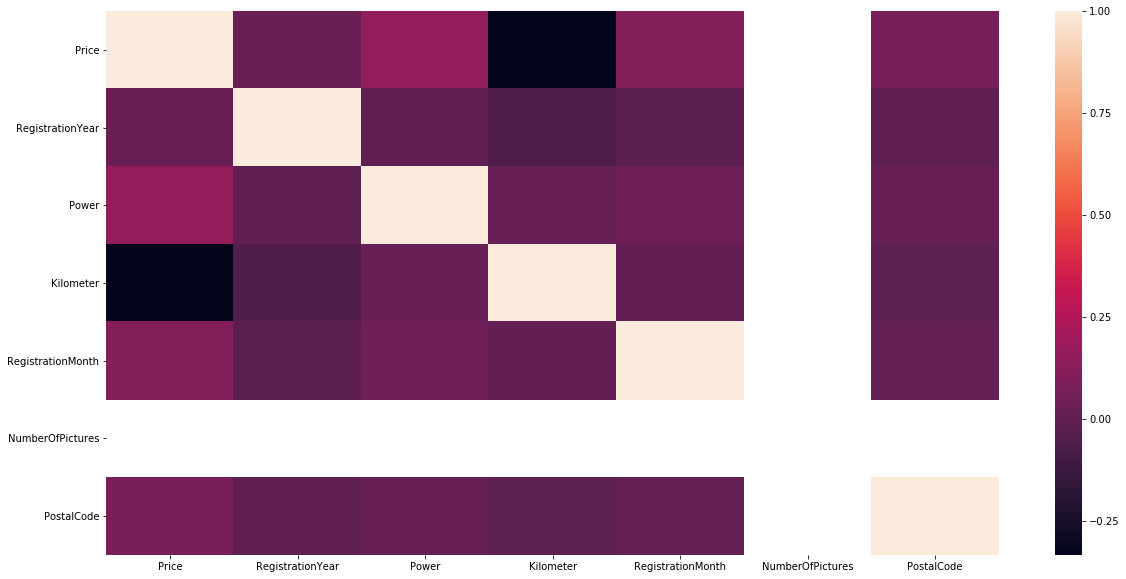

In [9]:
sns.heatmap(used_car_df.corr());

Можно увидеть явную обратную корреляцию между ценой и количеством киллометров. Очевидно, что чем больше проехал автомобиль тем дешевле он продается.

Многие другие признаки не имеют явной связи с ценой автомобиля и не несут нужной нам информации. Их стоит просто удалить. Уберем столбцы DateCrawled, RegistrationMonth, DateCreated, PostalCod и LastSeen.

In [10]:
used_car_df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures'], axis='columns', inplace=True)

In [11]:
used_car_df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')

In [12]:
used_car_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
Price               354365 non-null int64
VehicleType         354365 non-null object
RegistrationYear    354365 non-null int64
Gearbox             354365 non-null object
Power               354365 non-null int64
Model               354365 non-null object
Kilometer           354365 non-null int64
FuelType            354365 non-null object
Brand               354365 non-null object
NotRepaired         354365 non-null object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


Посмотрим теперь как распределены категориальные признаки. 

manual          268249
auto             66283
not-declared     19833
Name: Gearbox, dtype: int64


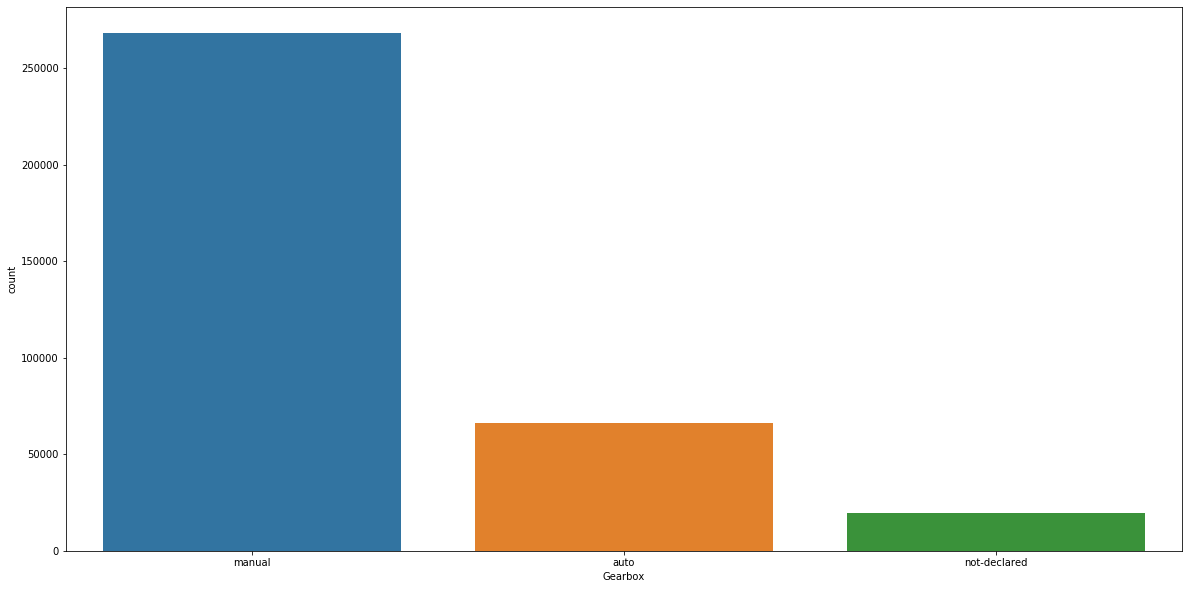

In [13]:
print(used_car_df['Gearbox'].value_counts())
sns.countplot(used_car_df['Gearbox']);

Большая часть машин продается с ручной коробкой передач (что вероятнее всего показывает, что данные исторические).

golf                  29232
other                 24420
3er                   19761
not-declared          19705
polo                  13066
                      ...  
i3                        8
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 251, dtype: int64


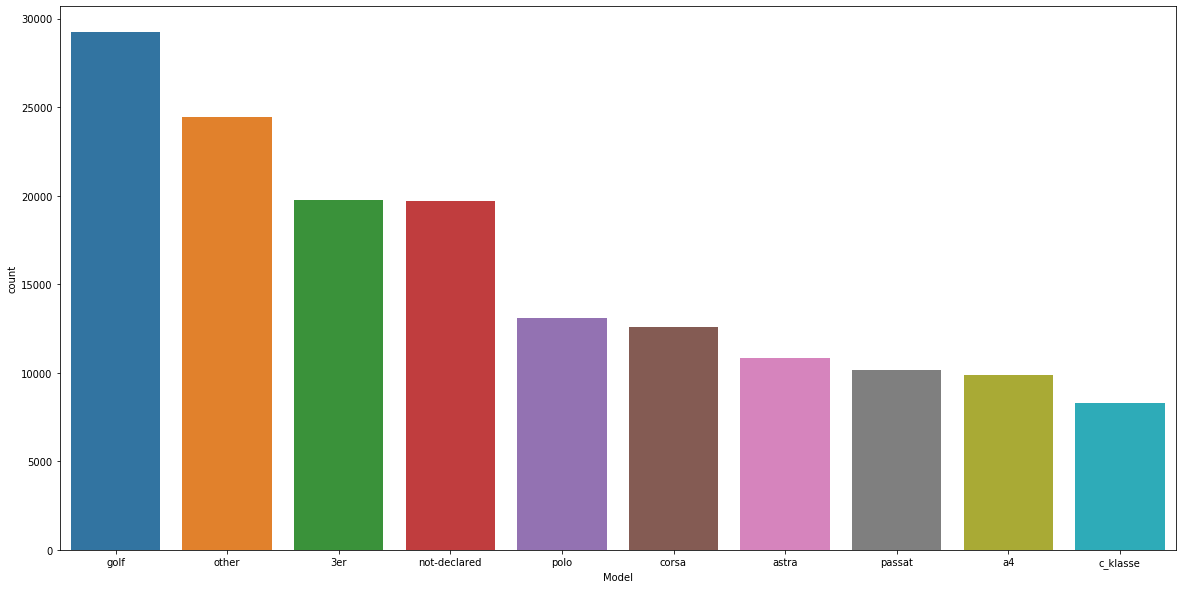

In [14]:
print(used_car_df['Model'].value_counts())
sns.countplot(used_car_df['Model'], order = used_car_df['Model'].value_counts().iloc[:10].index);

Самая продаваемая подержанная машина - volkswagen golf (и это вполне соответствует действительности).

volkswagen        77012
opel              39931
bmw               36914
mercedes_benz     32044
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2322
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: Brand, dtype: int64


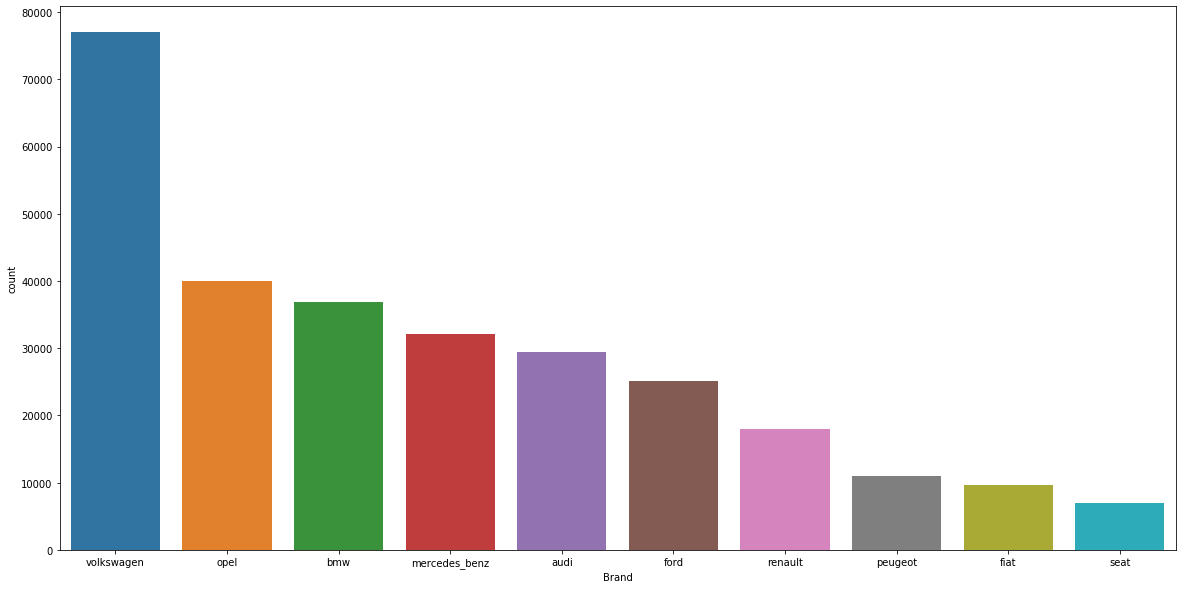

In [15]:
print(used_car_df['Brand'].value_counts())
sns.countplot(used_car_df['Brand'], order = used_car_df['Brand'].value_counts().iloc[:10].index);

Самый популярный бренд - все так же volkswagen.

sedan           91457
small           79830
wagon           65165
not-declared    37490
bus             28775
convertible     20203
coupe           16161
suv             11996
other            3288
Name: VehicleType, dtype: int64


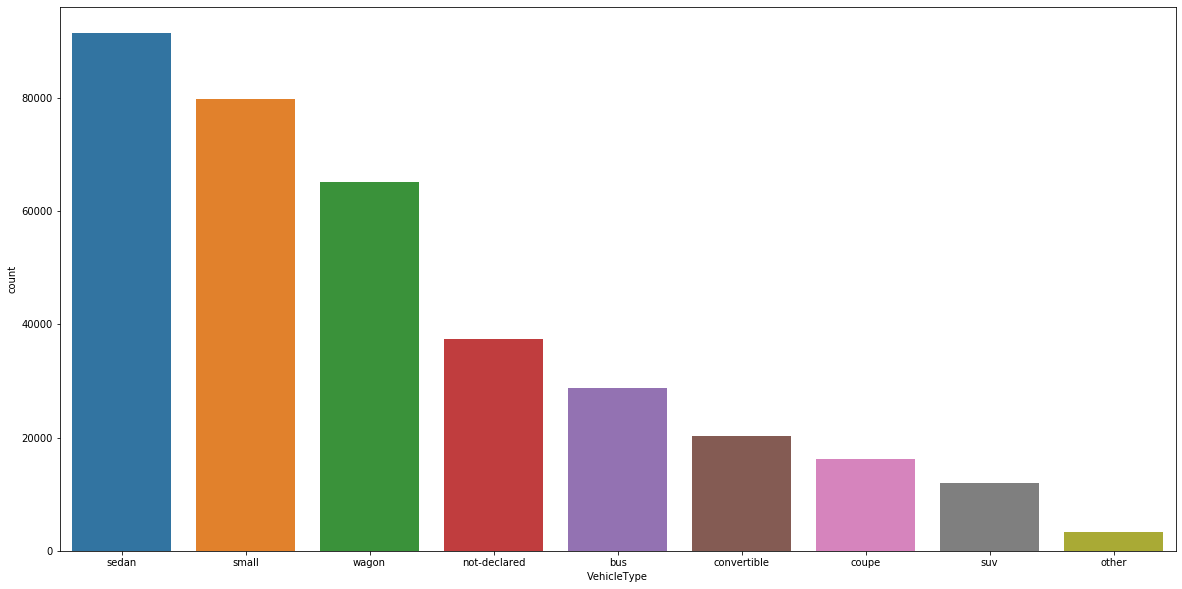

In [16]:
print(used_car_df['VehicleType'].value_counts())
sns.countplot(used_car_df['VehicleType'], order = used_car_df['VehicleType'].value_counts().index);

Судя по этим данным в мире продается достаточно много автобусов! Ну а самыми популярными классами автомобилей являются седаны и небольшие машины.

no              247158
not-declared     71154
yes              36053
Name: NotRepaired, dtype: int64


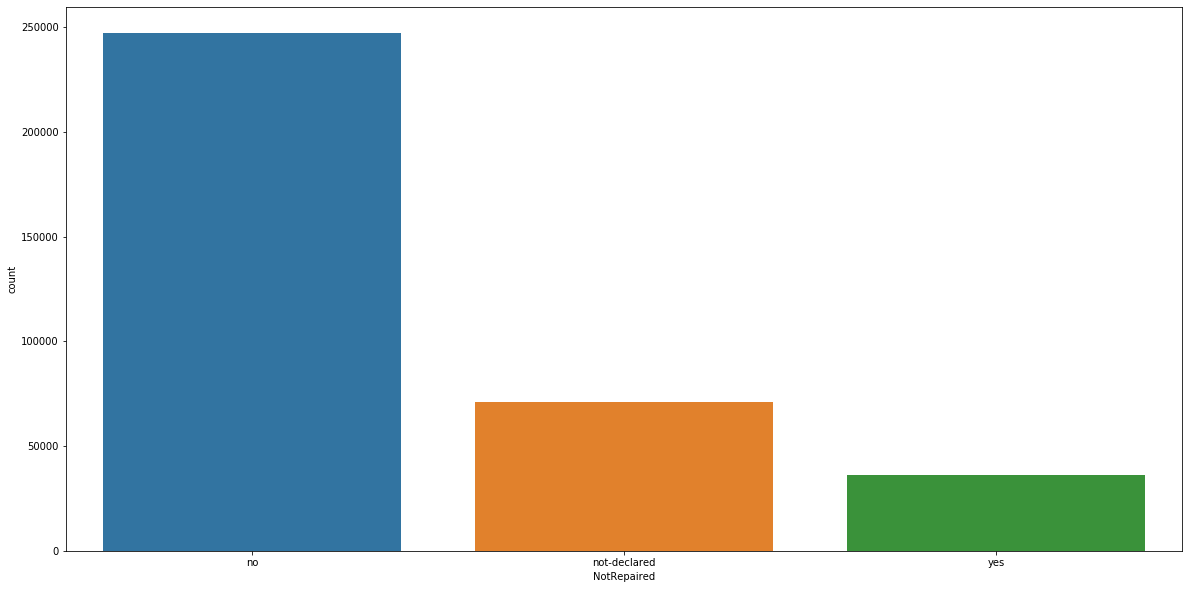

In [17]:
print(used_car_df['NotRepaired'].value_counts())
sns.countplot(used_car_df['NotRepaired'], order = used_car_df['NotRepaired'].value_counts().index);

Целых машин значительно больше, чем битых (и вполне возможно что продавцы не указавшие ничего в этом поле просто не признаются...)

petrol          216349
gasoline         98719
not-declared     32895
lpg               5310
cng                565
hybrid             233
other              204
electric            90
Name: FuelType, dtype: int64


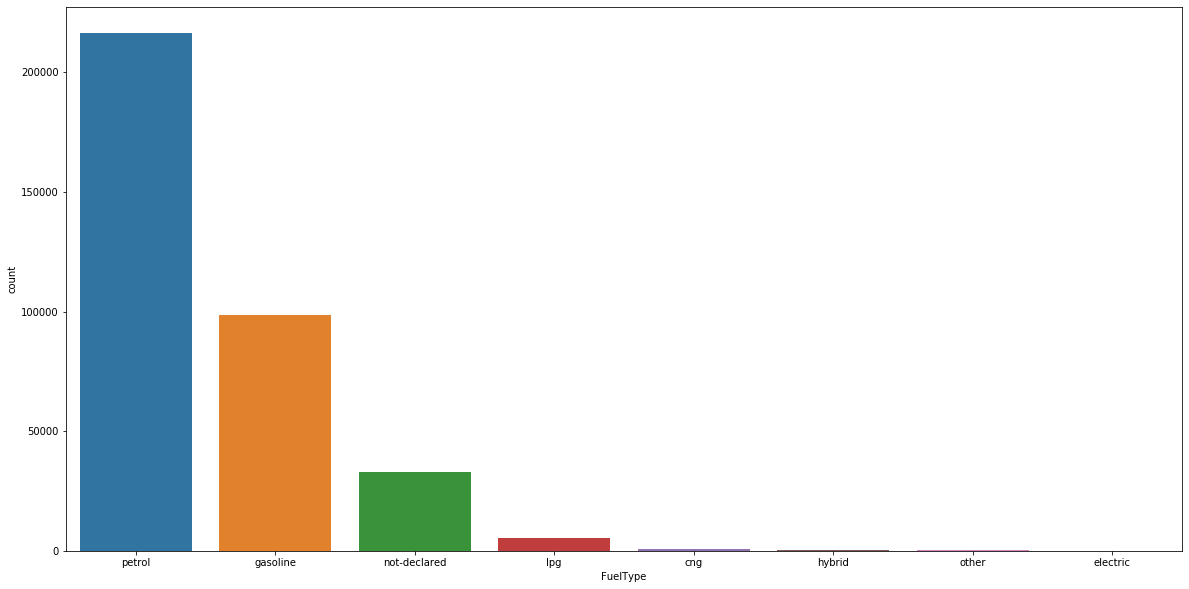

In [18]:
print(used_car_df['FuelType'].value_counts())
sns.countplot(used_car_df['FuelType'], order = used_car_df['FuelType'].value_counts().index);

С типом топлива несколько интереснее. Дело в том, что и petrol и gasoline обозначают ровным счетом одно и то же топливо, которое у нас называют бензином. Их следовало бы объединить в одну категорию, однако в данных нет ни одной машины на дизеле, что очень странно, и вполне возможно что тут просто ошибка в названии категорий. Поэтому пока трогать их не будем. 

___

Исследуем так же категориальные признаки. К ним относятся RegistrationYear, Power и Kilometer.

In [19]:
used_car_df.describe()

,Price,RegistrationYear,Power,Kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


В данных имеются очевиднейшие выбросы, например год регистрации больше нынешнего. Используя в первую очередь здравый смысл удалим из рассмотрения те записи, значения которых мало соответствуют реальности. Удалим Записи об автомобилях старше 1960 и моложе 2020 года (зарагестрировать машину в будущем вряд ли возможно, а слишком старые автомобили явно относятся к раритетам и обладают своими особенностями предсказаня цены, что для нас будет проблемой). Так же уберем автомобили дешевле 100 долларов (это явно выбросы, и причина по которой автомобили отдают чуть ли не бесплатно тоже нас не интересует). Так же удалим автомобили со слишком большой и слишком маленькой мощностью. К размером пробега на первый взгляд проблем нет.

In [20]:
len(used_car_df)

354365

In [21]:
used_car_df = used_car_df[
        (used_car_df['RegistrationYear'] <= 2020) 
      & (used_car_df['RegistrationYear'] >= 1960) 
      & (used_car_df['Price'] >= 100) 
      & (used_car_df['Power'] >= 10) 
      & (used_car_df['Power'] <= 500)]

In [22]:
len(used_car_df)

305198

Выкинули из датасета почти 50000 записей! 

Посмотрим на графики распределения того, что осталось.

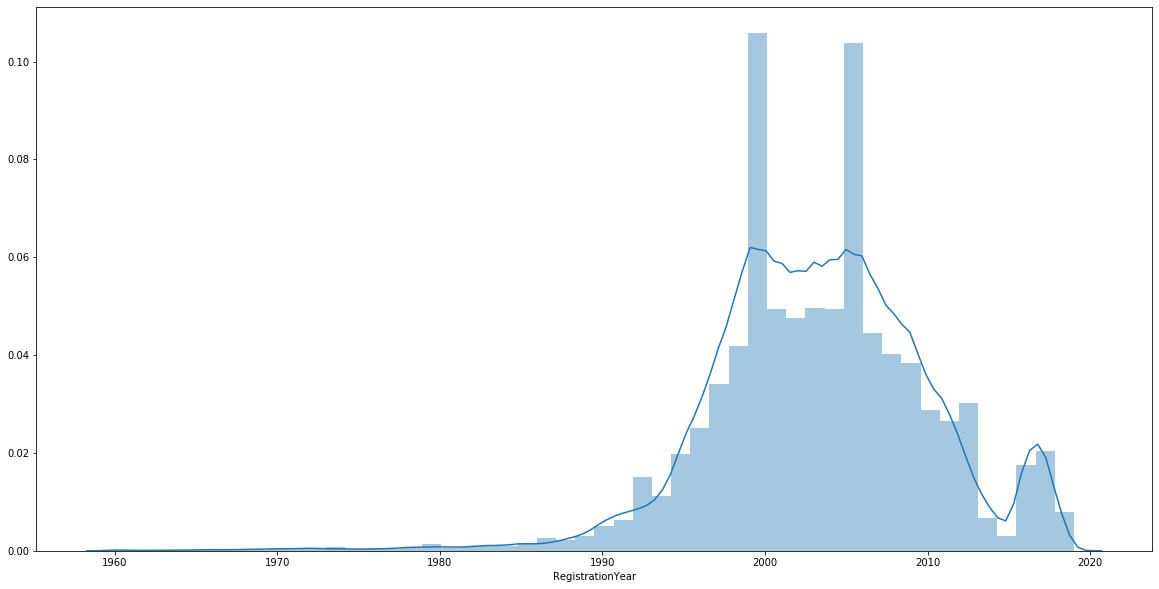

In [23]:
sns.distplot(used_car_df['RegistrationYear']);

Распределение близко к нормальному, что в целом можно ожидать для такого параметра

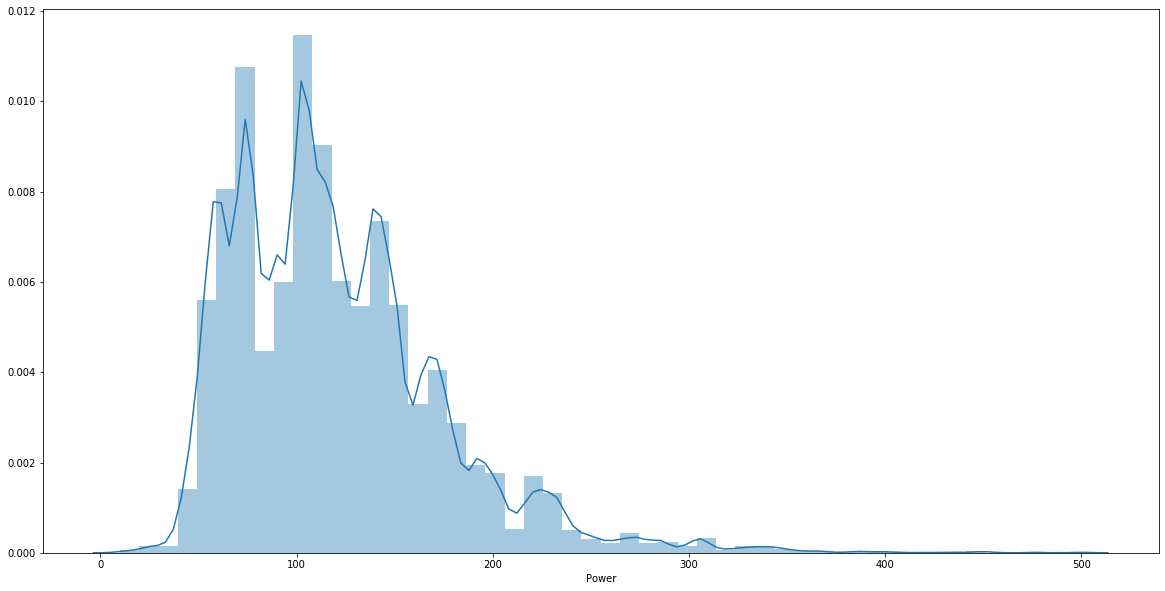

In [24]:
sns.distplot(used_car_df['Power']);

Здесь тоже все в порядке, видно, что машин с большой мощностью изчезающе мало, и большая часть их них занимает промежуток от 80-200 лс.

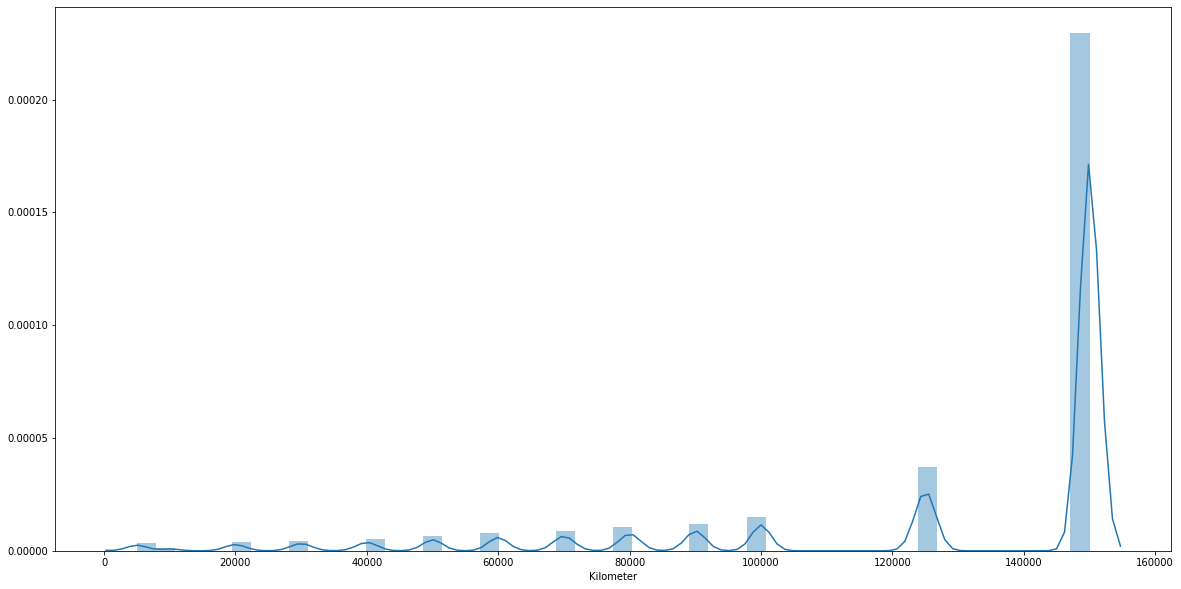

In [25]:
sns.distplot(used_car_df['Kilometer']);

Тут интереснее. Кажется, что 150000 км это максимальное значение, которое моожно ввести в базу данных. Соответственно у машин, пробек которых превышает это число он именно такой и указан. Более того, таких машин больше половины. Это в целом нормально для подержанных машин, и не совсем понятно, в почему киллометраж не измерен точнее, ведь здравый смысл говорит, что это один из важнейших показателей. Тут можно было бы наверное сделать этот признак бинарным, вроде "пробег больше 100 тысяч", но мне почему то кажется, что и малый пробег тут тоже важен.  

## Вывод

Была проведена загрузка и предобработка данных. Удалены дубликаты и мало коррелирующие с целевой переменной столбцы, пропуски категориальных признаков заполнены значением-заглушкой. 

# 2. Обучение моделей

Для начала разделим выборку на тренировочную и тестовую часть. Настраивать гиперпараметры моделей будем на кроссвалидации. Тестовая часть нужна для итогового сравнения моделей. Тренировочная часть будет составлять 20% датасета.

In [26]:
X = used_car_df.drop(['Price'], axis='columns', inplace=False)
y = used_car_df['Price']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
print(X_train.shape)
print(X_test.shape)
print(X_test.shape[0]/y_train.shape[0])

(244158, 9)
(61040, 9)
0.25000204785425834


Так как нам важна скорость предсказания и время обучения мы будет в дополнение к RMSE сравнивать и эти параметры различных моделей, и после составим сводную таблицу.

In [29]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

___

1. Константная модель

Константную модель будем использовать в первую очедь для проверки на адекватность. Но и обучеться она должна быстро... Предсказывать будем по медиане тренировочной выборки.

In [30]:
class ConstantPredictor:
    
    def fit(self, train_features, train_target):
        self.median = train_target.median()

    def predict(self, test_features):
        return np.ones(len(test_features)) * self.median

In [31]:
constant_pred = ConstantPredictor()

In [32]:
%%time
constant_pred.fit(X_train, y_train)

CPU times: user 8.72 ms, sys: 52 µs, total: 8.77 ms
Wall time: 8.3 ms


Обучение занимает 8.3 миллисекунд

In [33]:
%%time
y_const_pred = constant_pred.predict(X_test)

CPU times: user 879 µs, sys: 66 µs, total: 945 µs
Wall time: 627 µs


Предсказание на тестовом множестве занимает 627 микросекунд. Быстро!

Теперь проверим качество предсказания. 

In [34]:
rmse(y_test, y_const_pred)

4853.547267342413

RMSE равен 4854. Не сказать, что очень хорошо

___

2. Дерево решений

Проверим так же максимально простую модель, которая при этом должна показывать более адекватный результат, чем константное предсказание. В качестве такой модели используем дерево решений. 

Дерево решений из sklearn не очень понимает категориальные данные из коробки, поэтому необходимо произвести кодирование данных. Порядковое кодирование нам не подойдет, так-как данные не имеют значащего порядка. Поэтому для всех наших категориалных данных имеет смысл применять OneHotEncoding.

In [35]:
categorial = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
numeric = ['RegistrationYear', 'Power', 'Kilometer']

In [36]:
enc = OneHotEncoder(drop='first')

In [37]:
%%time
X_enc = pd.concat((pd.get_dummies(X[categorial], drop_first=True), 
                         X[numeric]), axis=1)
X_train_enc = X_enc.loc[X_train.index]
X_test_enc = X_enc.loc[X_test.index]

CPU times: user 2.08 s, sys: 184 ms, total: 2.27 s
Wall time: 2.3 s


In [38]:
X_train_enc.filter(like = 'NotRepaired')

,NotRepaired_not-declared,NotRepaired_yes
276572,1,0
53501,0,0
170693,1,0
261974,1,0
142860,0,0
...,...,...
139209,0,0
300827,0,0
153199,0,0
170524,0,1


Само кодирование исходного датасета занимает определенное время, поэтому его стоит прибавить ко времени обучения модели

In [39]:
tree_model = DecisionTreeRegressor()

In [40]:
%%time
tree_model.fit(X_train_enc, y_train)

CPU times: user 10.5 s, sys: 229 ms, total: 10.7 s
Wall time: 11 s


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

Обучение модели занимает целых 11.4 секунды. 

In [41]:
%%time
y_tree_pred = tree_model.predict(X_test_enc)

CPU times: user 108 ms, sys: 56.1 ms, total: 164 ms
Wall time: 183 ms


А вот предсказания делаются быстро, порядка 161 миллисекунды.

In [42]:
rmse(y_test, y_tree_pred)

1828.3642936860917

Качество модели так же значительно повысилось.

Используем GridSearchCV для поиска оптимальных гиперпараметров модели. Изменять будем параметры max_depth и min_samples_split.

In [43]:
tree_grid_model = DecisionTreeRegressor(random_state=42)

In [44]:
tree_param_dict = {'max_depth' : [10, 15, 25],
                   'min_samples_split' : [7, 10, 12]}

In [45]:
tree_grid = GridSearchCV(tree_grid_model, tree_param_dict, n_jobs=-1, cv = 3)

In [46]:
%%time
tree_grid.fit(X_train_enc, y_train)

CPU times: user 2min 27s, sys: 7.21 s, total: 2min 34s
Wall time: 2min 36s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=42,
                                             splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [10, 15, 25],
                         'min_samples_split': [7, 10, 12]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, v

In [47]:
tree_grid.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=25, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=12, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

Оптимальные параметры max_depth=25, min_samples_split=12

In [48]:
%%time
y_tree_grid_pred = tree_grid.predict(X_test_enc)

CPU times: user 90.1 ms, sys: 52 ms, total: 142 ms
Wall time: 157 ms


In [49]:
rmse(y_test, y_tree_grid_pred)

1736.0717006107595

3. LightGBM

Для начала работы с LightGBM необходимо создать контейнер, в котором ко всему прочему указать, какие переменные являются категориальными. При этом LightGBM понимает только категории типа int, так что предварительно закодируем их LabelEncoder'om

In [50]:
X_train_lbl = X_train.copy()
X_test_lbl = X_test.copy()

In [51]:
for category in categorial:
    lbl = LabelEncoder()
    X_train_lbl[category] = lbl.fit_transform(X_train_lbl[category])
    X_test_lbl[category] = lbl.transform(X_test_lbl[category])

In [52]:
train_data = lightgbm.Dataset(X_train_lbl, label=y_train, categorical_feature=categorial)
test_data = lightgbm.Dataset(X_test_lbl, label=y_test)

Зададим параметры обучения. Используем те же параметры, что и в настроенном одиночном 

In [53]:
parameters = {
    'objective': 'regression', # очевидно потому что у нас регрессия
    'metric': 'l2', # метрика mse с регуляризацией l2
    'boosting': 'gbdt', # стандартный бустинг над решающими деревьями
    'learning_rate': 0.1,
    'verbose': 1,
    'stratified': False,
    'max_depth': 25
}

Создадим модель регрессии. Используем трехкратную кроссвалидацию, а так же установим максимальное количество итераций бустинга на 100.

In [54]:
%%time
model_lgbm = lightgbm.train(parameters,
                       train_data,
                       categorical_feature=categorial,
                       num_boost_round=200)

CPU times: user 21.3 s, sys: 165 ms, total: 21.4 s
Wall time: 21.6 s


Само обучение занимает 21.6 секунды

In [55]:
%%time
y_lgbm_pred = model_lgbm.predict(X_test_lbl)

CPU times: user 1.72 s, sys: 1.06 ms, total: 1.72 s
Wall time: 1.79 s


Предсказание - 1.79 секунды

In [56]:
rmse(y_test, y_lgbm_pred)

1584.820749257236

Качество модели очевидно лучше, чем у одиночного дерева и тем более у константного предсказания.

Посмотрим, какие признаки важны для построения модели. 

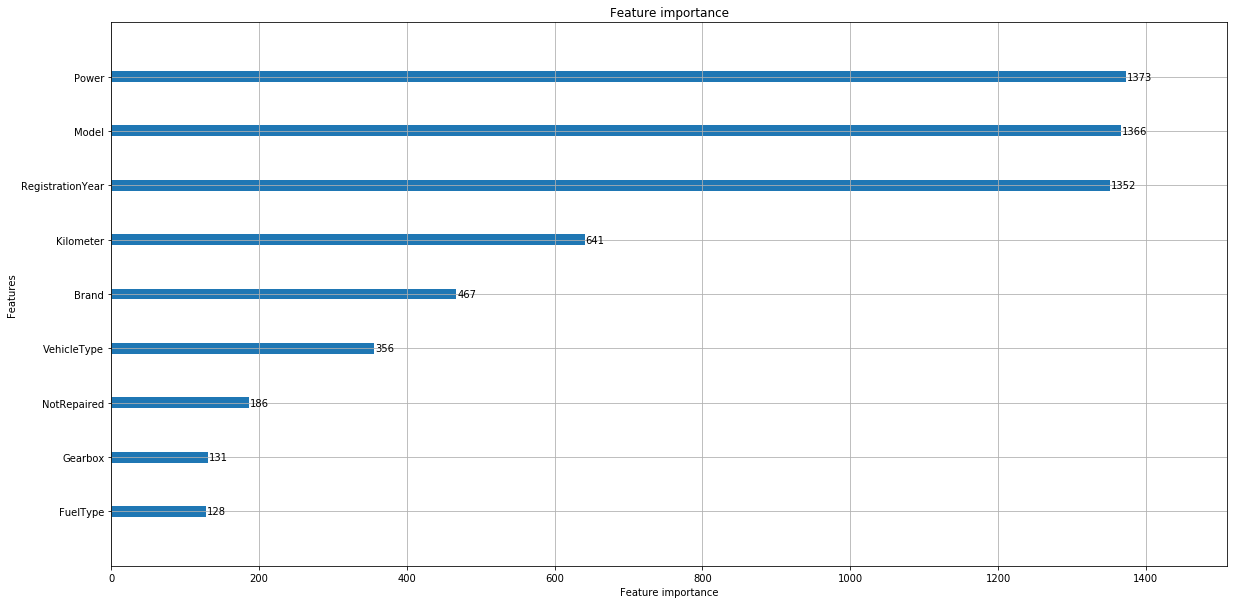

In [57]:
lightgbm.plot_importance(model_lgbm);

Видно, что самые важные признаки для определения цены это мощность, модель и возраст. Все это кажется очень логичным. 

4. CatBoost

Опробуем так же CatBoost. Создать модель с его помощью даже несколько проще. Обучим его так же на 300 итерациях.

In [58]:
model_cat = CatBoostRegressor(iterations=200, eval_metric='RMSE', learning_rate=0.1, random_seed=42)

In [59]:
%%time
model_cat.fit(X_train, y_train,
             cat_features=categorial)

0:	learn: 4282.8935754	total: 973ms	remaining: 3m 13s
1:	learn: 4023.7544771	total: 1.87s	remaining: 3m 5s
2:	learn: 3792.7336060	total: 2.77s	remaining: 3m 2s
3:	learn: 3582.3042737	total: 3.67s	remaining: 2m 59s
4:	learn: 3401.6473973	total: 4.67s	remaining: 3m 2s
5:	learn: 3241.7173052	total: 5.57s	remaining: 3m
6:	learn: 3098.9030367	total: 6.38s	remaining: 2m 55s
7:	learn: 2962.1553571	total: 7.37s	remaining: 2m 56s
8:	learn: 2849.9850927	total: 8.27s	remaining: 2m 55s
9:	learn: 2752.6056161	total: 9.07s	remaining: 2m 52s
10:	learn: 2658.3119050	total: 9.97s	remaining: 2m 51s
11:	learn: 2585.9310372	total: 10.8s	remaining: 2m 48s
12:	learn: 2519.9146059	total: 11.7s	remaining: 2m 47s
13:	learn: 2454.2858589	total: 12.5s	remaining: 2m 45s
14:	learn: 2395.0497319	total: 13.4s	remaining: 2m 44s
15:	learn: 2338.5025610	total: 14.4s	remaining: 2m 45s
16:	learn: 2288.7547091	total: 15.3s	remaining: 2m 44s
17:	learn: 2248.2489266	total: 16.2s	remaining: 2m 43s
18:	learn: 2208.8794552	tot

In [60]:
%%time
y_cat_pred = model_cat.predict(X_test)

CPU times: user 322 ms, sys: 29.4 ms, total: 351 ms
Wall time: 349 ms


In [61]:
rmse(y_test, y_cat_pred)

1686.1501787103205

Посмотрим так же какие признаки модель считает самыми важными. 

In [62]:
importances = pd.DataFrame(model_cat.feature_importances_, index = X_train.columns, columns=['Importance'])

In [63]:
importances

,Importance
VehicleType,9.774242
RegistrationYear,37.431067
Gearbox,0.274144
Power,24.573517
Model,3.894494
Kilometer,12.435596
FuelType,2.132354
Brand,6.889603
NotRepaired,2.594984


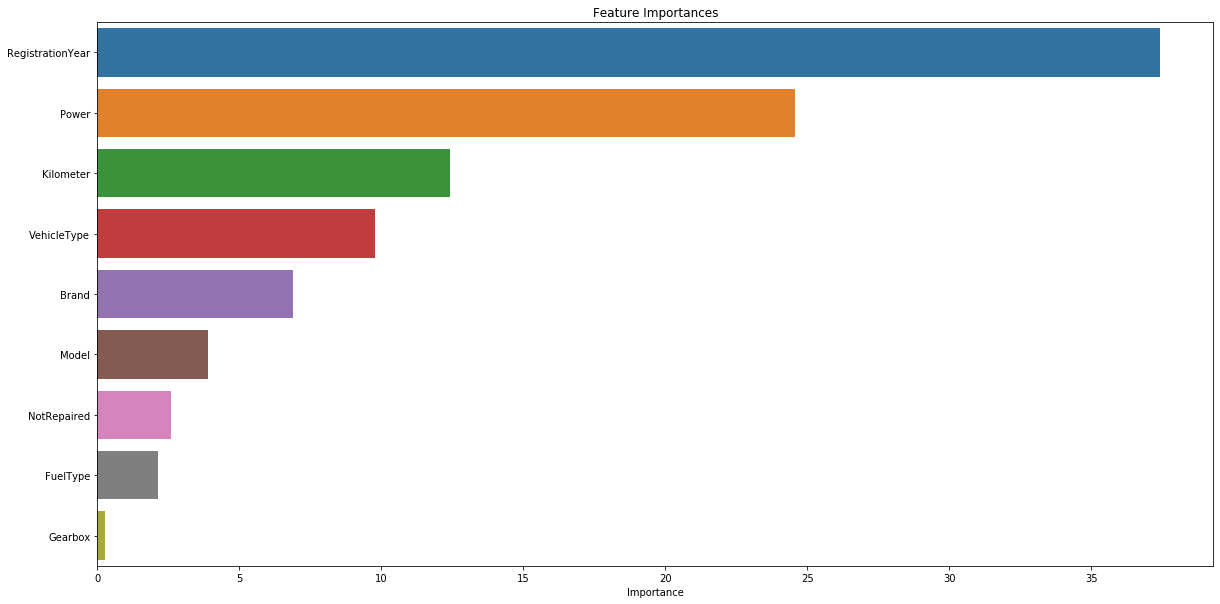

In [64]:
sns.barplot(data=importances, x='Importance', y=importances.index, 
            order = importances.sort_values(by='Importance', ascending = False).index)
plt.title('Feature Importances');  

Для CatBoost самым важным параметром оказался год регистрации. Интересно, что в отличае от LGBM модель автомобиля для него не очень важна. В остальном важность признаков для обоих этих моделей похожа.

# 3. Анализ моделей

Составим сводную таблицу исследованных моделей.

| Модель | Качество предсказания  (RMSE) | Скорость предсказания, c | Скорость обучения, c |
|:-:|:-:|:-:|:-:|
| Константная модель | 4853 | $627\cdot10^{-6}$ | $8.3\cdot10^{-3}$ |
| Дерево решений | 1828 | $183\cdot10^{-3}$ | 11+2.3|
| LightGBM | 1585 | 1.78 | 21.6 |
| CatBoost | 1686 | $349\cdot10^{-3}$ | 173 |

Итак, быстрее всего, очевидно, работет константная модель, ведь все что ей нужно это запомнить медианное значение тренировочного датасета и предсказать его для всех экземпляров тестового множества. Однакое её качество мало подходит для нас. Дерево решений простое, быстро обучается и показывает неплохую точность, однако модели с использованием бустинга показывают себя гораздо лучше.  

Качество LightGBM и CatBoost приблизительно сопоставимы, а вот у времени работы каждой модели бустинга из этих библиотек имеет свои особенности.  
Так, LightGBM быстро обучается, время обучения на 100 итерациях приблизительно сопоставимо со временем обучения одиночного дерева. Однако при этом предсказания занимают гораздо больше времени.  
У CatBoost ситуация прямо обратная, время предсказания сопоставимо с таковым у одиночного дерева, а вот обучение происходит значительно дольше.   

В итоге выбор модели зависит от того, какие именно параметры важнее для данного заказчика. Если важна именно скорость предсказания и можно позволить себе потратить время на обучение - лучше использовать CatBoost. Если скорость обучения более важна, хорошо покажет себя LightGBM.